In [190]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import equinox as eqx
import jax
import jax.numpy as jnp
from typing import Optional, Tuple
from jaxtyping import PRNGKeyArray, Array, Float, PyTree
import numpy as np
import gymnax
import rlax
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
from icecream import ic
import gymnasium as gym

In [178]:
def get_total_discounted_rewards(rewards: Float[Array, "n_steps"], gamma=0.99) -> Array:
    """Calculate the total discounted rewards for a given set of rewards.
    This is also known as the rewards-to-go.

    Args:
        rewards: The rewards to calculate the total discounted rewards for.
        gamma: The discount factor.
    Returns:
        The total discounted rewards.
    """

    def scan_fn(carry, current_reward):
        discounted_reward = carry + current_reward
        return discounted_reward * gamma, discounted_reward

    _, total_discounted_rewards = jax.lax.scan(scan_fn, 0.0, rewards[::-1])

    total_discounted_rewards = total_discounted_rewards[::-1].reshape(
        -1,
    )
    assert (
        total_discounted_rewards.shape == rewards.shape
    ), f"total_discounted_rewards.shape: {total_discounted_rewards.shape}, rewards.shape: {rewards.shape}"

    return total_discounted_rewards

In [191]:
@eqx.filter_jit
def calculate_gae(
    rewards: Array,
    values: Array,
    dones: Array,
    gamma: float,
    lam: float,
) -> Array:
    def body_fun(
        carry: tuple[Array, Array], t: Array
    ) -> tuple[tuple[Array, Array], None]:
        advantages, gae_inner = carry
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae_inner = delta + gamma * lam * (1 - dones[t]) * gae_inner
        advantages = advantages.at[t].set(gae_inner)
        return (advantages, gae_inner), None

    values = jnp.append(values, values[0])
    advt = jnp.zeros_like(rewards)
    gae = jnp.array(0.0)
    t = len(rewards)

    (advt, _), _ = jax.lax.scan(body_fun, (advt, gae), jnp.arange(t - 1, -1, -1))
    return advt

In [180]:
def rollout(rng_input, policy, env, env_params, steps_in_episode, epoch):
    """Rollout a jitted gymnax episode with lax.scan."""
    # Reset the environment
    rng_reset, rng_episode = jax.random.split(rng_input)
    obs, state = env.reset(rng_reset, env_params)
    
    def policy_step(state_input, tmp):
        """lax.scan compatible step transition in jax env."""
        obs, state, rng = state_input
        rng, rng_step, rng_net = jax.random.split(rng, 3)
        logits = policy(obs)
        action = jax.random.categorical(logits=logits, key=rng_net)
        log_prob = jax.nn.log_softmax(logits)[action]
        next_obs, next_state, reward, done, _ = env.step(
          rng_step, state, action, env_params
        )
        carry = [next_obs, next_state, rng]
        return carry, [obs, action, log_prob, reward, done, state]

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      policy_step,
      [obs, state, rng_episode],
      (),
      steps_in_episode
    )
    # Return masked sum of rewards accumulated by agent in episode
    obs, action, log_prob, reward, done, states = scan_out
    return obs, action, log_prob, reward, done, states

In [202]:
def rollout_gym(
    env: gym.Env,
    policy: PyTree,
    key: PRNGKeyArray,
    render: bool = False,
    max_steps: Optional[int] = None,
) -> tuple[RLDataset, dict]:
    """Rollout a policy in a gym environment."""

    obs, info = env.reset()

    observations = []
    actions = []
    log_probs = []
    rewards = []
    dones = []
    info = None

    while True:
        key, subkey = jax.random.split(key)
        observations.append(obs)
        logits = policy(obs)
        action = jax.random.categorical(logits=logits, key=subkey)
        action = np.array(action)
        log_prob = np.array(jax.nn.log_softmax(np.array(logits)))
        log_probs.append(log_prob[action])
        obs, reward, terminated, truncated, info = env.step(action)
        if render:
            env.render()
        done = terminated or truncated
        actions.append(action)
        rewards.append(reward)
        dones.append(done)

        if max_steps is not None and len(observations) < max_steps:
            if done:
                obs, _ = env.reset()
        elif max_steps is not None and len(observations) >= max_steps:
            break
        else:
            if done:
                break

    dataset = (
        np.array(observations),
        np.array(actions),
        np.array(rewards),
        np.array(log_probs),
        np.array(dones),
    )

    return dataset


In [203]:
class RLDataset(Dataset):
    def __init__(self, states, actions, rewards, log_probs, values, advantages, dones) -> None:
        self.rewards = torch.tensor(rewards)
        self.actions = torch.tensor(actions)
        self.obs = torch.tensor(states)
        self.dones = torch.tensor(dones)
        self.log_probs = torch.tensor(log_probs)
        self.values = torch.tensor(values)
        self.advantages = torch.tensor(advantages)

    def __len__(self) -> int:
        return len(self.rewards)

    def __getitem__(
        self, idx
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor,
               torch.Tensor, torch.Tensor, torch.Tensor, 
               torch.Tensor]:
        return (
            self.obs[idx],
            self.actions[idx],
            self.rewards[idx],
            self.log_probs[idx],
            self.values[idx],
            self.advantages[idx],
            self.dones[idx],
        )

In [204]:
class Actor(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, in_size: int,
                 out_size: int,
                 width_size: int,
                 depth: int,
                 *,
                 key: PRNGKeyArray):
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=width_size,
            depth=depth,
            key=key
        )
    
    def __call__(self, x: Array, key: Optional[PRNGKeyArray] = None):
        return self.mlp(x)

class Critic(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, in_size: int,
                 width_size: int,
                 depth: int,
                 *,
                 key: PRNGKeyArray):
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=1,
            width_size=width_size,
            depth=depth,
            key=key
        )
    
    def __call__(self, x: Array, key: Optional[PRNGKeyArray] = None):
        return self.mlp(x)
        

In [205]:
@eqx.filter_jit
def get_value(obs: Float[Array, "n_dims"], critic: PyTree) -> Array:
    return critic(obs)

In [206]:
jit_rollout = eqx.filter_jit(rollout)

In [211]:
@eqx.filter_jit
def update_ppo(actor: PyTree,
               actor_optimizer: optax.GradientTransformation,
               actor_opt_state: optax.OptState,
               critic: PyTree,
               critic_optimizer: optax.GradientTransformation,
               critic_opt_state: optax.OptState,
               batch: Tuple[Array],
               policy_clip: float = 0.2,
              ):
    # print("JIT")
    obs, actions, rewards, old_log_probs, values, advantages, dones = batch
    def ppo_objective(_actor, _obs, _old_log_probs, _advantages):
        new_logits = eqx.filter_vmap(actor)(obs)
        log_probs = jax.nn.log_softmax(new_logits)
        new_log_probs = jnp.take_along_axis(
            log_probs, jnp.expand_dims(actions, -1), axis=1
        ).reshape(-1)
        prob_ratio = jnp.exp(new_log_probs) / jnp.exp(old_log_probs)
        
        """
        weighted_probs = advantages * prob_ratio
        weighted_clipped_probs = jnp.clip(prob_ratio, 
                                          1.0 - policy_clip, 1.0 + policy_clip) * advantages
        clipped_objective = jnp.fmin(weighted_probs, weighted_clipped_probs)
        return -clipped_objective.mean()
        """
        return rlax.clipped_surrogate_pg_loss(
            prob_ratios_t=prob_ratio,
            adv_t=advantages.reshape(-1),
            epsilon=policy_clip,
            use_stop_gradient=False
        )
    
    def actor_step(_actor, _obs, _old_log_probs, _advantages, _actor_optimizer, 
                   _actor_opt_state):
        grad = eqx.filter_grad(ppo_objective)(_actor, _obs, _old_log_probs, _advantages)
        updates, _actor_opt_state = _actor_optimizer.update(grad, _actor_opt_state, _actor)
        _actor = eqx.apply_updates(_actor, updates)
        
        return _actor, _actor_opt_state
    
    def critic_loss(_critic, _obs, _advantages, _values):
        critic_values = eqx.filter_vmap(_critic)(obs)
        returns = _advantages + _values
        loss = (returns - critic_values) ** 2
        return loss.mean()
    
    def critic_step(_critic, _obs, _advantages, _values,
                    _critic_optimizer, _critic_opt_state):
        grad = eqx.filter_grad(critic_loss)(_critic, _obs, _advantages, _values)
        updates, _critic_opt_state = _critic_optimizer.update(grad, _critic_opt_state, _critic)
        _critic = eqx.apply_updates(_critic, updates)
        
        return _critic, _critic_opt_state
    
    actor, actor_opt_state = actor_step(actor, obs, old_log_probs, advantages,
                                        actor_optimizer, actor_opt_state)
    
    critic, critic_opt_state = critic_step(critic, obs, advantages, values, critic_optimizer,
                                           critic_opt_state)
    
    return actor, actor_opt_state, critic, critic_opt_state

In [222]:
policy_clip = 0.2
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# Create the Pendulum-v1 environment
env, env_params = gymnax.make("CartPole-v1")
jit_rollout = eqx.filter_jit(rollout)

In [223]:
key, actor_key, critic_key = jax.random.split(jax.random.PRNGKey(33), 3)
actor = Actor(in_size=env.observation_space(env_params).shape[0], 
             out_size=env.action_space(env_params).n,
             width_size=32,
             depth=2,
             key=actor_key)
critic = Critic(in_size=env.observation_space(env_params).shape[0], 
             width_size=32,
             depth=2,
             key=critic_key)
actor_optimizer = optax.adamw(learning_rate=0.001)
actor_opt_state = actor_optimizer.init(eqx.filter(actor, eqx.is_inexact_array))

critic_optimizer = optax.adamw(learning_rate=0.001)
critic_opt_state = critic_optimizer.init(eqx.filter(critic, eqx.is_inexact_array))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.75it/s]


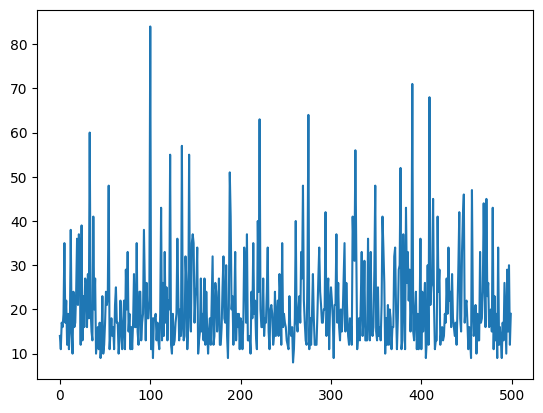

In [228]:
rng = jax.random.PRNGKey(33)
n_episodes = 500
n_epochs = 100
batch_size = 128
env = gym.make("CartPole-v1")
all_rewards = []
for eps in tqdm(range(n_episodes)):
    rng, subkey = jax.random.split(rng)
    # obs, actions, log_probs, rewards, dones, states = jit_rollout(subkey, actor, env, env_params, 256, 0)
    obs, actions, rewards, log_probs, dones = rollout_gym(env, actor, key=subkey)

    true_indices = jnp.where(dones)[0]
    distances = jnp.diff(true_indices, prepend=-1)

    # Calculate average distance
    avg_distance = jnp.mean(distances)
    all_rewards.append(jnp.sum(rewards))
    
    # all_rewards.append(jnp.sum(dones))
    
    values = jax.vmap(get_value, in_axes=(0, None))(obs, critic)
    advantages = calculate_gae(
        rewards = rewards,
        values = values,
        dones = dones,
        gamma = 0.98,
        lam = 0.9
    )
    #advantages = rlax.truncated_generalized_advantage_estimation(
    #    rewards.reshape(-1)[1:],
    #    jnp.array([0.99] * (len(rewards) - 1)),
    #    lambda_=0.95,
    #    values=values.reshape(-1)
    #).reshape(-1, 1)
    #advantages = jnp.append(advantages, advantages[-1])
    dataset = RLDataset(
        rewards=np.array(rewards),
        states=np.array(obs),
        actions=np.array(actions),
        log_probs=np.array(log_probs),
        dones=np.array(dones),
        values=np.array(values),
        advantages=np.array(advantages)
    )
    dataloader = DataLoader(batch_size=batch_size,
                        shuffle=True, drop_last=True,
                        dataset=dataset)
    for epoch in range(n_epochs):
        for batch in dataloader:
            obs, actions, rewards, old_log_probs, values, advantages, dones = batch
            b = (
                jnp.array(obs.numpy()),
                jnp.array(actions.numpy()), 
                jnp.array(rewards.numpy()),
                jnp.array(old_log_probs.numpy()),
                jnp.array(values.numpy()),
                jnp.array(advantages.numpy()), 
                jnp.array(dones.numpy())
            )
            actor, actor_opt_state, critic, critic_opt_state = update_ppo(actor, actor_optimizer, actor_opt_state, 
               critic, critic_optimizer, critic_opt_state, b, policy_clip=0.2)

plt.plot(all_rewards)
plt.show()